In [286]:
# utils imports
import pdb
import time
import numpy as np
import pandas as pd
import random
from collections import deque
import os
import matplotlib.pyplot as plt

# Gym imports
from gym.spaces import Discrete, Box

# Keras imports
import tensorflow as tf
import keras
import keras.models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

In [287]:
class DQN:
    def __init__(self, memory_size=5*10**5, batch_size=32, gamma=0.99,
        exploration_max=1.0, exploration_min=0.01, exploration_decay=0.995,
        learning_rate=0.005, tau=0.125, n_actions=2, n_inputs=2):
        
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.exploration_max = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.learning_rate = learning_rate
        self.tau = tau

        self.action_space = Discrete(n_actions)
        self.observation_space = Box(low=np.array([0,0]), high=np.array([3,1]), dtype=np.int32)

        self.aux_model = self.create_model()
        self.target_model = self.create_model()
        self.loss_history = []
        self.fit_count = 0

        self.nodes_queue = []

    def create_model(self):
        _model = Sequential()
        _model.add(Dense(24, input_dim=self.observation_space.shape[0], activation="relu"))
        _model.add(Dense(24, activation="relu"))
        _model.add(Dense(self.action_space.n))
        _model.compile(loss="mse", 
                       optimizer=Adam(learning_rate=self.learning_rate))

        return _model
        
    def get_action(self, state, should_explore=True):
        if should_explore:
            self.exploration_max *= self.exploration_decay
            self.exploration_max = max(self.exploration_min, self.exploration_max)
            if np.random.random() < self.exploration_max:
                return self.action_space.sample()
        
        # q_values = self.model.predict(state, verbose=0)
        q_values = self.aux_model(state).numpy()
        best_action = np.argmax(q_values[0])
        return best_action
      
    def remember(self, _state, action, reward, _next_state, done):
        state = _state
        next_state = _next_state
        self.memory.append([state, action, reward, next_state, done])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 
        
        samples = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        targets = []

        for state, action, reward, next_state, done in samples:
            
            target = self.target_model(state).numpy()
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model(next_state).numpy()[0])
                target[0][action] = reward + Q_future * self.gamma
            
            targets.append(target)
            
        states = np.array([i[0] for i in states])
        targets = np.array([i[0] for i in targets])
        self.loss_history.append(self.aux_model.fit(states, targets,verbose=0).history['loss'][0])
        return self.loss_history[-1]
        
    def target_train(self):
        weights = self.aux_model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)
    
    def step(self, state, action):

        next_state = state.copy()
        if action == 0:
            next_state[0][0] -= 1
        else: 
            next_state[0][0] += 1
        
        done = False
        if next_state[0][0] == 0 or next_state[0][0] == 3:
            done = True

        if next_state[0][1] == 1 and next_state[0][0] == 1:
            next_state[0][1] = 0

        return next_state, done

    def calc_reward(self, state, next_state, done):
        if next_state[0][0] == 0:
            return -10
        elif next_state[0][0] == 3:
            return 10
        elif state[0][1] == 1 and next_state[0][0] == 1:
            return 3
        else:
            return 0

    def reset_env(self):
        done = False
        state = np.array([[2,1]])
        return state, done
        
    def save_model(self, fn):
        self.aux_model.save('dqn-models/'+fn)
    
    def load_model(self, filename):
        self.aux_model = tf.keras.models.load_model(filename)

    def print_model(self):
        self.aux_model.summary()

DDQN = DQN()

In [288]:
episodes = 1000
rewards = []
losses = []
r = []
inner_loss = []
for ep in range(episodes):
    state, done = DDQN.reset_env()
    r = []
    l = []
    while not done:
        action = DDQN.get_action(state)
        next_state, done = DDQN.step(state, action)
        reward = DDQN.calc_reward(state, next_state, done)
        
        DDQN.remember(state.copy(), action, reward, next_state.copy(), done)
        # print("State: ", state, "Action: ", action, "Reward: ", reward, "Next State: ", next_state)
        if len(DDQN.memory) > 100:  
            loss = DDQN.replay() 
        else:
            loss = 1000

        state = next_state
        
        l.append(loss)
        r.append(reward)

    losses.append(np.mean(l))
    rewards.append(np.sum(r))
    if len(DDQN.memory) > 100:  DDQN.target_train()
    print(f"Episode:{ep}, Ep Reward: {rewards[-1]}, Last Loss: {losses[-1]}, Exploration: {DDQN.exploration_max}")

Episode:0, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.995
Episode:1, Ep Reward: 13, Last Loss: 1000.0, Exploration: 0.9801495006250001
Episode:2, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.9752487531218751
Episode:3, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.9703725093562657
Episode:4, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.9655206468094844
Episode:5, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.960693043575437
Episode:6, Ep Reward: -7, Last Loss: 1000.0, Exploration: 0.9511101304657719
Episode:7, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.946354579813443
Episode:8, Ep Reward: -7, Last Loss: 1000.0, Exploration: 0.9369146928798039
Episode:9, Ep Reward: -7, Last Loss: 1000.0, Exploration: 0.9275689688183278
Episode:10, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.9229311239742362
Episode:11, Ep Reward: 10, Last Loss: 1000.0, Exploration: 0.918316468354365
Episode:12, Ep Reward: -7, Last Loss: 1000.0, Exploration: 0.9091562615825302
Episode:13, 

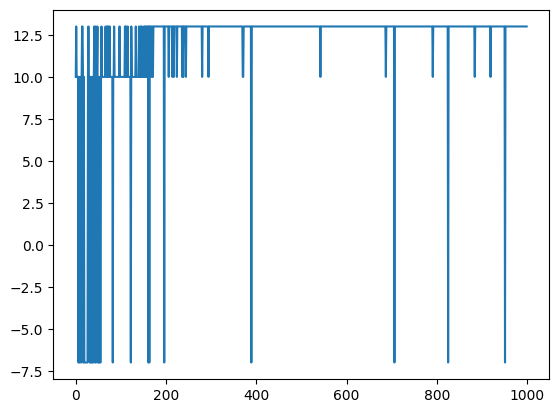

In [289]:
plt.plot(rewards)

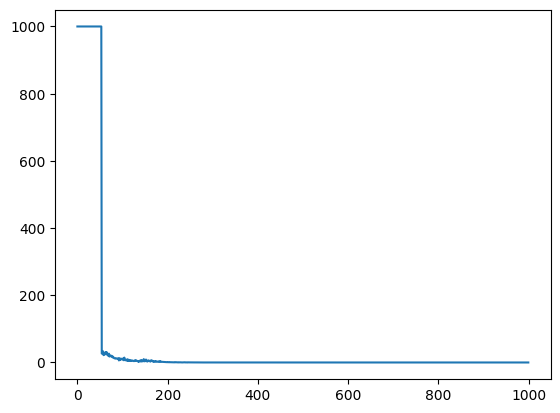

In [290]:
plt.plot(losses)